# Construção Manual de Árvore de Decisão com Gini
Neste notebook, vamos calcular a impureza de Gini para diferentes divisões de um pequeno dataset fictício e construir a árvore com base na melhor divisão.

In [1]:
import pandas as pd
from graphviz import Source
from graphviz import Digraph
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
data = {
    'idade': [22, 35, 26, 45, 27, 50, 29, 41, 33, 38, 24, 48],
    'fumante': [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
    'pressao': ['alta', 'baixa', 'normal', 'alta', 'baixa', 'normal',
                'normal', 'alta', 'baixa', 'baixa', 'normal', 'alta'],
    'doenca':  [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1]
}

df = pd.DataFrame(data)
df

,idade,fumante,pressao,doenca
0,22,0,alta,0
1,35,1,baixa,1
2,26,0,normal,0
3,45,1,alta,1
4,27,0,baixa,1
5,50,1,normal,1
6,29,1,normal,1
7,41,0,alta,0
8,33,1,baixa,1
9,38,0,baixa,0


In [3]:
# Funções para cálculo da impureza de Gini
def gini_impurity(y):
    prob = y.value_counts(normalize=True)
    return 1 - sum(prob ** 2)

def weighted_gini(groups):
    total = sum(len(group) for group in groups)
    return sum((len(group) / total) * gini_impurity(group) for group in groups)

In [4]:
# Gini do conjunto completo
gini_total = gini_impurity(df['doenca'])
gini_total

0.48611111111111105

In [5]:
# Gini para divisão: pressao
groups = [df[df['pressao'] == v]['doenca'] for v in df['pressao'].unique()]
gini_pressao = weighted_gini(groups)
gini_pressao

0.45833333333333326

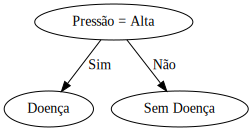

In [6]:
tree1 = Digraph()
tree1.attr(rankdir='TB')
tree1.node('A', 'Pressão = Alta')
tree1.node('B', 'Doença')
tree1.node('C', 'Sem Doença')
tree1.edge('A', 'B', label='Sim')
tree1.edge('A', 'C', label='Não')
tree1

In [7]:
# Gini para divisão: fumante
left = df[df['fumante'] == 1]['doenca']
right = df[df['fumante'] == 0]['doenca']
gini_fumante = weighted_gini([left, right])
gini_fumante

0.13888888888888884

In [8]:
# Gini para divisão: idade <= 30
left = df[df['idade'] <= 30]['doenca']
right = df[df['idade'] > 30]['doenca']
gini_idade = weighted_gini([left, right])
gini_idade

0.4380952380952381

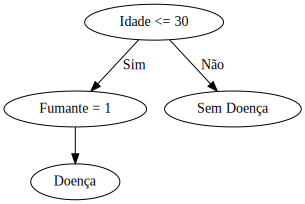

In [9]:
tree2 = Digraph()
tree2.attr(rankdir='TB')
tree2.node('X', 'Idade <= 30')
tree2.node('Y', 'Fumante = 1')
tree2.node('Z', 'Doença')
tree2.node('W', 'Sem Doença')
tree2.edge('X', 'Y', label='Sim')
tree2.edge('X', 'W', label='Não')
tree2.edge('Y', 'Z')
tree2

In [28]:
# Ordenar as idades únicas
idades_unicas = sorted(df['idade'].unique())

# Calcular os pontos médios entre pares consecutivos
cortes = [(idades_unicas[i] + idades_unicas[i+1]) / 2 for i in range(len(idades_unicas) - 1)]

melhor_gini = float('inf')
melhor_corte = None

print("Cortes testados e respectivos valores de Gini:\n")

for corte in cortes:
    esquerda = df[df['idade'] <= corte]['doenca']
    direita = df[df['idade'] > corte]['doenca']
    gini = weighted_gini([esquerda, direita])
    
    print(f"Corte: idade <= {corte:.1f} | Gini: {gini:.4f}")
    
    if gini < melhor_gini:
        melhor_gini = gini
        melhor_corte = corte

print("\nMelhor divisão encontrada:")
print(f"Idade <= {melhor_corte:.1f} | Gini correspondente: {melhor_gini:.4f}")

Cortes testados e respectivos valores de Gini:

Corte: idade <= 23.0 | Gini: 0.4242
Corte: idade <= 25.0 | Gini: 0.3500
Corte: idade <= 26.5 | Gini: 0.2593
Corte: idade <= 28.0 | Gini: 0.3750
Corte: idade <= 31.0 | Gini: 0.4381
Corte: idade <= 34.0 | Gini: 0.4722
Corte: idade <= 36.5 | Gini: 0.4857
Corte: idade <= 39.5 | Gini: 0.4583
Corte: idade <= 43.0 | Gini: 0.3704
Corte: idade <= 46.5 | Gini: 0.4167
Corte: idade <= 49.0 | Gini: 0.4545

Melhor divisão encontrada:
Idade <= 26.5 | Gini correspondente: 0.2593


In [26]:
# Comparando os resultados
resultados = pd.DataFrame({
    'Critério': ['Total', 'Idade <= ' + str(melhor_corte), 'Fumante', 'Pressão Arterial'],
    'Gini': [gini_total, gini_idade, gini_fumante, gini_pressao]
})
resultados = resultados.sort_values(by="Gini", ascending=True).reset_index(drop=True)
resultados

,Critério,Gini
0,Fumante,0.138889
1,Idade <= 26.5,0.438095
2,Pressão Arterial,0.458333
3,Total,0.486111


In [23]:
# Pré-processamento: transformar variáveis categóricas
df_encoded = pd.get_dummies(df, columns=["pressao"], drop_first=True)
df_encoded.head(3)

,idade,fumante,doenca,pressao_baixa,pressao_normal
0,22,0,0,False,False
1,35,1,1,True,False
2,26,0,0,False,True


In [ ]:
# Separar X e y
X = df_encoded.drop(columns="doenca")
y = df_encoded["doenca"]

# Treinar a árvore
clf = DecisionTreeClassifier(random_state=42, max_depth=3)  # você pode ajustar max_depth se quiser
clf.fit(X, y)

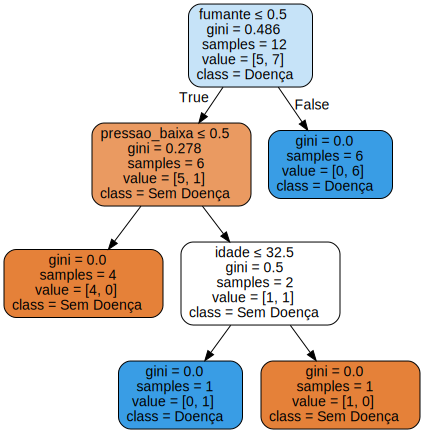

In [20]:
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=X.columns,
    class_names=["Sem Doença", "Doença"],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = Source(dot_data)
graph.render("arvore_final", format="png", cleanup=True)
graph